# Neural networks pruning
State-of-the-art neural networks nowadays have become extremely parameterized in order to maximize the prediction accuracy. However, the models also become costly to run and the inference latency become a bottleneck. On resource-constrained edge devices, the models have a lot of restrictions and cannot be parameterized as much as we can.

Sparse neural networks could perform as good as dense neural network with respect to the prediction accuracy, and the inference latency becomes much lower theoretically due to its small model size.

Neural network pruning is a method to create sparse neural networks from pre-trained dense neural networks. It is the process of deleting parameters from an existing neural network, which might involve removing individual parameters or groups of parameters.

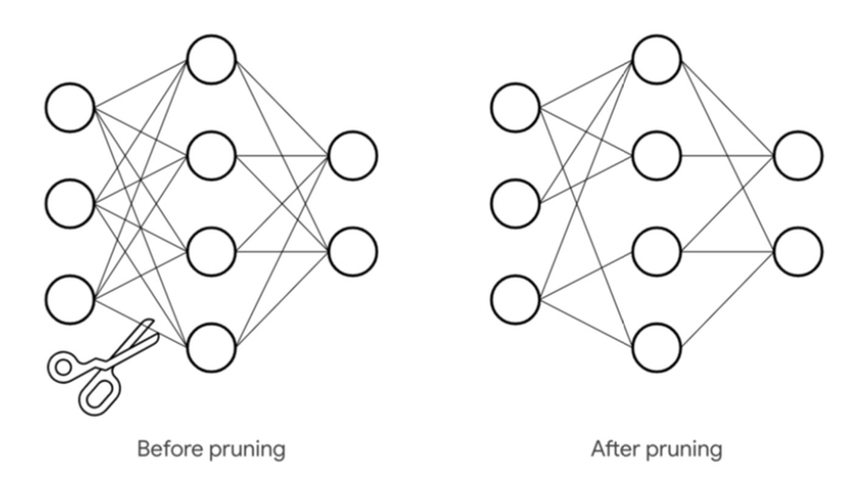

Today, we'll use PyTorch built-in pruning tools. Note, that there are a lot of other tools you can use for this purpose. Use this link for PyTorch pruning reference and documentation: https://pytorch.org/tutorials/intermediate/pruning_tutorial.html.

First, import nessessery libraries.

In [24]:
import torch
import time
import numpy as np
import tqdm

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import (
    ToTensor,
    RandomRotation,
    Compose,
    RandomCrop,
    RandomAffine,
)
from typing import Union, List, Tuple, Any
from abc import ABC, abstractmethod
import torch.nn.functional as F
from tabulate import tabulate
import matplotlib.pyplot as plt
import torch.nn.utils.prune as prune

Let's start with pretrained model. As usual, we'll use simple CNN model (like in Laboratory 1) and MNIST dataset. Don't use sequential blocks!

Train model for 5 epochs - you should get around ~98% accuracy.

Name the final trained model `CNN_MNIST`.

In [25]:
from abc import ABC, abstractmethod
from typing import Any


class BaseMetric(ABC):

    @abstractmethod
    def __call__(self, y_pred, y_ref) -> Any:
        raise NotImplementedError()


class AccuracyMetric(BaseMetric):

    def __init__(self) -> None:
        pass

    @torch.no_grad()
    def __call__(
        self, y_pred: torch.Tensor, y_ref: torch.Tensor
    ) -> torch.Tensor:
        """
        :param y_pred: tensor of shape (batch_size, num_of_classes) type float
        :param y_ref: tensor with shape (batch_size,) and type Long
        :return: scalar tensor with accuracy metric for batch
        """
        predicted_classes = torch.argmax(
            y_pred, dim=1
        )
        correct_predictions = (
            predicted_classes == y_ref
        ).float() 
        score: torch.Tensor = (
            correct_predictions.mean()
        ) 

        return score

In [26]:
def draw_loss_test(epochs, history):
    loss_train = history["loss_train"]
    loss_test = history["loss_test"]
    acc_train = history["acc_train"]
    acc_test = history["acc_test"]

    loss_train_shape = len(loss_train)
    loss_test_shape = len(loss_test)
    acc_train_shape = len(acc_train)
    acc_test_shape = len(acc_test)

    if (
        loss_train_shape != loss_test_shape
        or acc_train_shape != acc_test_shape
    ):
        raise ValueError(
            f"Different number of epochs for train and test loss: {loss_train_shape} != {loss_test_shape} or train and test accuracy: {acc_train_shape} != {acc_test_shape}"
        )

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["loss_train"], label="Train loss")
    plt.plot(epochs, history["loss_test"], label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["acc_train"], label="Train accuracy")
    plt.plot(epochs, history["acc_test"], label="Test accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

In [27]:
def train_one_epoch(
    model, train_loader, loss_fn, metric, optimizer, update_period, device
):
    model.train()
    total_loss_train = 0.0
    total_acc_train = 0.0
    samples_num_train = 0

    with tqdm.tqdm(train_loader, colour="red", ncols=100) as t:
        for i, (X, y) in enumerate(t):
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()

            if (i + 1) % update_period == 0:
                optimizer.step()
                optimizer.zero_grad()

            accuracy = metric(y_pred, y)
            batch_size = y.size(0)
            total_loss_train += loss.item() * batch_size
            total_acc_train += accuracy.item() * batch_size
            samples_num_train += batch_size

            current_loss = total_loss_train / samples_num_train
            current_acc = total_acc_train / samples_num_train

            t.set_postfix(
                loss=f"{current_loss:.4f}", accuracy=f"{current_acc:.4f}"
            )

    epoch_loss_train = total_loss_train / samples_num_train
    epoch_acc_train = total_acc_train / samples_num_train

    return epoch_loss_train, epoch_acc_train


def test_one_epoch(model, test_loader, loss_fn, metric, device):
    model.eval()
    total_loss_test = 0.0
    total_acc_test = 0.0
    samples_num_test = 0

    with torch.no_grad():
        with tqdm.tqdm(test_loader, colour="green", ncols=100) as t:
            for X, y in t:
                X, y = X.to(device), y.to(device)

                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                accuracy = metric(y_pred, y)

                batch_size = y.size(0)
                total_loss_test += loss.item() * batch_size
                total_acc_test += accuracy.item() * batch_size
                samples_num_test += batch_size

                current_loss = total_loss_test / samples_num_test
                current_acc = total_acc_test / samples_num_test

                t.set_postfix(
                    loss=f"{current_loss:.4f}", accuracy=f"{current_acc:.4f}"
                )

    epoch_loss_test = total_loss_test / samples_num_test
    epoch_acc_test = total_acc_test / samples_num_test

    return epoch_loss_test, epoch_acc_test


def test_or_train(
    model,
    train_loader,
    test_loader,
    loss_fn,
    metric,
    optimizer,
    update_period,
    epoch_max,
    device,
    mode="train",
    early_stopping_accuracy=None,
):
    loss_train = []
    loss_test = []
    acc_train = []
    acc_test = []

    for e in range(epoch_max):
        print(f"Epoch: {e + 1}/{epoch_max}")

        if mode in ["train", "both"]:
            epoch_loss_train, epoch_acc_train = train_one_epoch(
                model,
                train_loader,
                loss_fn,
                metric,
                optimizer,
                update_period,
                device,
            )
            loss_train.append(epoch_loss_train)
            acc_train.append(epoch_acc_train)

        if mode in ["test", "both"]:
            epoch_loss_test, epoch_acc_test = test_one_epoch(
                model, test_loader, loss_fn, metric, device
            )
            loss_test.append(epoch_loss_test)
            acc_test.append(epoch_acc_test)

        if (
            early_stopping_accuracy
            and epoch_acc_train >= early_stopping_accuracy
        ):
            print(
                f"Training accuracy of {epoch_acc_train:.4f} achieved, stopping training."
            )
            break

    return model, {
        "loss_train": loss_train,
        "acc_train": acc_train,
        "loss_test": loss_test,
        "acc_test": acc_test,
    }

In [28]:
class CNN(torch.nn.Module):
    def __init__(self, input_shape, num_of_cls) -> None:
        super().__init__()
        ch_in = input_shape[0]
        self.conv1 = nn.Conv2d(ch_in,32,3,padding=(1,1))
        self.conv2 = nn.Conv2d(32,64,3,padding=(1,1))
        self.conv3 = nn.Conv2d(64,128,3)

        self.batch1 = nn.BatchNorm2d(32)
        self.batch2 = nn.BatchNorm2d(64)
        self.batch3 = nn.BatchNorm2d(128)

        self.flat = nn.Flatten()
        self.fc = nn.Linear(128*5*5, num_of_cls)
        self.soft = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.batch1(self.conv1(x))), (2,2))
        x = F.max_pool2d(F.relu(self.batch2(self.conv2(x))), (2,2))
        x = F.relu(self.batch3(self.conv3(x)))
        x = self.flat(x)
        x = self.fc(x)
        y = self.soft(x)
        return y

torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {torch_device}")

train_transform = Compose(
    [
        RandomCrop(28, padding=4),
        RandomAffine(degrees=15, translate=(0.1, 0.1)),
        ToTensor(),
    ]
)

test_transform = Compose([ToTensor()])

try:
    train_dataset = datasets.MNIST(
        root="./data", train=True, download=True, transform=train_transform
    )
    test_dataset = datasets.MNIST(
        root="./data", train=False, download=True, transform=test_transform
    )
except Exception as e:
    print(f"Failed to download MNIST dataset: {e}")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

input_shape = (1, 28, 28)
output_size = 10

CNN_MNIST = CNN(input_shape, output_size)
metric = AccuracyMetric()
loss_fcn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(CNN_MNIST.parameters(), lr=0.01)

CNN_MNIST, history = test_or_train(
    model=CNN_MNIST,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fcn,
    metric=metric,
    optimizer=optimizer,
    update_period=1,
    epoch_max=5,
    device=torch_device,
    mode='both',
    early_stopping_accuracy=0.99
)

Using device: cpu
Epoch: 1/5


100%|███████████████████████████████| 157/157 [00:01<00:00, 94.50it/s, accuracy=0.8609, loss=1.6342]


Epoch: 2/5


100%|███████████████████████████████| 157/157 [00:01<00:00, 99.15it/s, accuracy=0.9578, loss=1.5431]


Epoch: 3/5


100%|███████████████████████████████| 157/157 [00:01<00:00, 88.53it/s, accuracy=0.9699, loss=1.5094]


Epoch: 4/5


100%|██████████████████████████████| 157/157 [00:01<00:00, 108.73it/s, accuracy=0.9778, loss=1.4940]


Epoch: 5/5


100%|███████████████████████████████| 157/157 [00:01<00:00, 88.49it/s, accuracy=0.9699, loss=1.5038]


In [29]:
headers = history.keys()
rows = zip(*history.values())
print(tabulate(rows, headers=headers, tablefmt="pretty"))

+--------------------+--------------------+--------------------+----------+
|     loss_train     |     acc_train      |     loss_test      | acc_test |
+--------------------+--------------------+--------------------+----------+
| 1.9835237809499104 | 0.5357333333333333 | 1.6342001171112062 |  0.8609  |
| 1.721871508916219  | 0.7916333333333333 | 1.5431348686218263 |  0.9578  |
| 1.613429826927185  | 0.8980166666666667 | 1.5093568948745728 |  0.9699  |
| 1.5702816195805867 | 0.9247666666666666 | 1.4939585817337036 |  0.9778  |
| 1.5513832059860229 | 0.9352166666666667 | 1.5038055366516114 |  0.9699  |
+--------------------+--------------------+--------------------+----------+


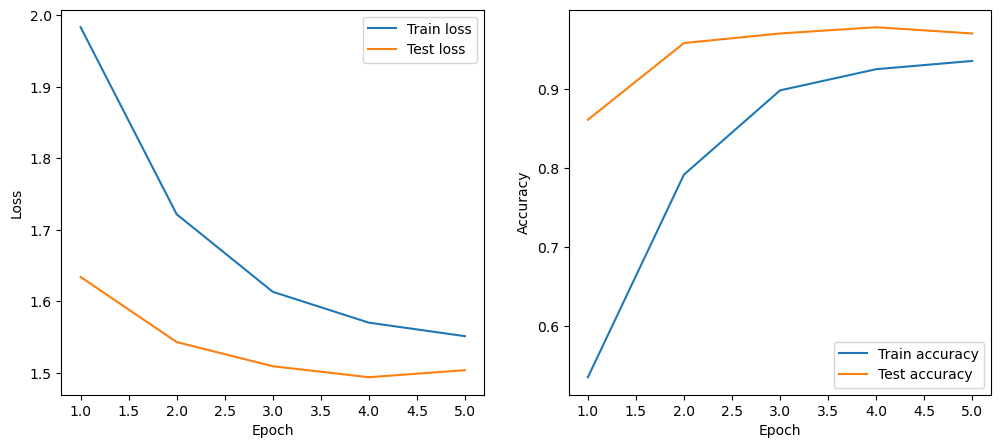

In [30]:
epochs = range(1, len(history["loss_train"]) + 1)
draw_loss_test(epochs, history)

In [31]:
model_path = "./models/CNN_MNIST.pth"
optimizer_path = "./models/optimizer.pth"

torch.save(CNN_MNIST.state_dict(), model_path)
torch.save(optimizer.state_dict(), optimizer_path)

Now, we can start our pruning. First...

# Unstructured Pruning
When talking about the cost of neural networks, the count of parameters is surely one of the most widely used metrics, along with FLOPS (floating-point operations per second). It is indeed intimidating to see networks displaying astronomical amounts of weights (up to billions for some), often correlated with stellar performance. Therefore, it is quite intuitive to aim at reducing directly this count by removing parameters themselves.

Directly pruning parameters has many advantages. First, it is simple, since replacing the value of their weight with zeros, within the parameter tensors, is enough to prune a connection. Moreover it is easy to do without hurting the performance of the network. As pruning weights is not limited by any constraint at all and is the finest way to prune a network, such a paradigm is called **unstructured pruning**.

Let's start with simplest case - random unstructured pruning!

First - create net model `CNN_MNIST_RND` and load trained weigts to it, with `load_state_dict` function.

Then, for each Convolutional Layer of this network, perform random unstructured pruning for 25% of all weights.

To do that, use `prune.random_unstructured()` function.
- the network layer is passed as the first argument to the function (you can get it with `model.layer_name`),
- `name` identifies the parameter within that module using its string identifier - we update `weight`,
-  and `amount` indicates the percentage of connections to prune (a float between 0. and 1.).

In [32]:
CNN_MNIST_RND = CNN(input_shape, output_size)
optimizer_RND = torch.optim.SGD(CNN_MNIST_RND.parameters(), lr=0.01)
CNN_MNIST_RND.load_state_dict(torch.load(model_path))
optimizer_RND.load_state_dict(torch.load(optimizer_path))

prune.random_unstructured(CNN_MNIST_RND.conv1, name='weight', amount=0.25)
prune.random_unstructured(CNN_MNIST_RND.conv2, name='weight', amount=0.25)
prune.random_unstructured(CNN_MNIST_RND.conv3, name='weight', amount=0.25)

/var/folders/0b/brzkvl1j0tn9xzynh5pr39sw0000gn/T/ipykernel_41132/3090656321.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNN_MNIST_RND.load_state_dict(torch.load(mode

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))

Did it work? Let's find out!

First - evaluate both `CNN_MNIST_RND` and `CNN_MNIST` networks on testing dataset and print the accuracies. Compare them.

Then, calculate the sparsity for `CNN_MNIST_RND` model with the following function.

Finally, compare `model.layer_name.weight` attributes for both networks for selected layer. Are some weights zeroed?

In [33]:
#TODO: evaluate both models
epoch_loss_test_CNN_MNIST, epoch_acc_test_CNN_MNIST = test_one_epoch(
    model=CNN_MNIST,
    test_loader=test_loader,
    loss_fn=loss_fcn,
    metric=metric,
    device=torch_device
)
epoch_loss_test_CNN_MNIST_RND, epoch_acc_test_CNN_MNIST_RND = test_one_epoch(
    model=CNN_MNIST_RND,
    test_loader=test_loader,
    loss_fn=loss_fcn,
    metric=metric,
    device=torch_device
)

#TODO: print accuracy
print(f"\nLoss CNN_MNIST: {epoch_loss_test_CNN_MNIST}")
print(f"Loss CNN_MNIST_RND: {epoch_loss_test_CNN_MNIST_RND}")

print(f"\nAccuracy CNN_MNIST: {epoch_acc_test_CNN_MNIST}")
print(f"Accuracy CNN_MNIST_RND: {epoch_acc_test_CNN_MNIST_RND}")


#TODO: print sparsity
print(
     "\nSparsity in CNN_MNIST_RND: {:.2f}%".format(
         100. * float(torch.sum(CNN_MNIST_RND.conv1.weight == 0)
                      + torch.sum(CNN_MNIST_RND.conv2.weight == 0)
                      + torch.sum(CNN_MNIST_RND.conv3.weight == 0)
                      )
         / float(CNN_MNIST_RND.conv1.weight.nelement()
                      + CNN_MNIST_RND.conv2.weight.nelement()
                      + CNN_MNIST_RND.conv3.weight.nelement()
                      )
    )
)

#TODO: print model.layer_name.weight for both networks
print(f"\nCNN_MNIST: {CNN_MNIST.conv1.weight}")
print(f"CNN_MNIST_RND: {CNN_MNIST_RND.conv1.weight}")

100%|███████████████████████████████| 157/157 [00:01<00:00, 90.86it/s, accuracy=0.2973, loss=2.1546]


Loss CNN_MNIST: 1.5038055459976196
Loss CNN_MNIST_RND: 2.1545987129211426

Accuracy CNN_MNIST: 0.9699
Accuracy CNN_MNIST_RND: 0.2973

Sparsity in CNN_MNIST_RND: 25.00%

CNN_MNIST: Parameter containing:
tensor([[[[ 1.1281e-01,  1.1982e-02, -2.0876e-01],
          [-4.0135e-02, -2.3847e-01, -2.1541e-01],
          [-3.1714e-01,  6.2022e-02,  2.8589e-01]]],


        [[[ 3.0213e-01,  1.5608e-01,  6.6971e-02],
          [-6.8164e-02,  3.2047e-01, -2.9736e-01],
          [ 3.0410e-01,  1.2493e-01, -2.9945e-01]]],


        [[[ 1.0763e-01,  2.7385e-01, -1.6146e-01],
          [ 1.2897e-01,  6.9826e-02, -3.0639e-01],
          [ 2.0600e-02,  1.1757e-01,  3.0314e-01]]],


        [[[-2.3809e-01,  2.1078e-02,  2.5110e-01],
          [-1.2423e-02,  1.0331e-01, -2.2537e-03],
          [-1.6206e-01,  5.2711e-02,  1.4573e-01]]],


        [[[-1.4972e-01, -1.7935e-01, -6.4516e-02],
          [-2.2977e-01,  2.2091e-01, -2.5053e-01],
          [-9.0160e-02,  4.7625e-02,  2.4756e-02]]],


        [[[-

Well, pruning random weights is simple but inefficient. A real challenge in pruning is determining what to prune. If you are removing weights or nodes from a model, you want the parameters that you remove to be less useful. There are different heuristics and methods of determining which nodes are less important and can be removed with minimal effect on accuracy.

For that, we can use L1 norm to find the smallest (least important) parameters.

First - create net model `CNN_MNIST_L1` and load trained weigts to it, with `load_state_dict` function.

Then, for each Convolutional Layer of this network, perform L1 unstructured pruning for 25% of all weights.

To do that, replace `prune.random_unstructured()` with `prune.l1_unstructured()` function. Evaluate the new network, calculate its sparsity and compare its weights.

In [34]:
CNN_MNIST_L1 = CNN(input_shape, output_size)
optimizer_L1 = torch.optim.SGD(CNN_MNIST_L1.parameters(), lr=0.01)
CNN_MNIST_L1.load_state_dict(torch.load(model_path))
optimizer_L1.load_state_dict(torch.load(optimizer_path))

prune.l1_unstructured(CNN_MNIST_L1.conv1, name='weight', amount=0.25)
prune.l1_unstructured(CNN_MNIST_L1.conv2, name='weight', amount=0.25)
prune.l1_unstructured(CNN_MNIST_L1.conv3, name="weight", amount=0.25)

# TODO: evaluate model
epoch_loss_test_CNN_MNIST_L1, epoch_acc_test_CNN_MNIST_L1 = test_one_epoch(
    model=CNN_MNIST_L1,
    test_loader=test_loader,
    loss_fn=loss_fcn,
    metric=metric,
    device=torch_device,
)

# TODO: print accuracy
print(f"\nLoss CNN_MNIST_L1: {epoch_loss_test_CNN_MNIST_L1}")
print(f"Accuracy CNN_MNIST_L1: {epoch_acc_test_CNN_MNIST_L1}")

# TODO: print sparsity
print(
    "\nSparsity in CNN_MNIST_L1: {:.2f}%".format(
        100.0
        * float(
            torch.sum(CNN_MNIST_L1.conv1.weight == 0)
            + torch.sum(CNN_MNIST_L1.conv2.weight == 0)
            + torch.sum(CNN_MNIST_L1.conv3.weight == 0)
        )
        / float(
            CNN_MNIST_L1.conv1.weight.nelement()
            + CNN_MNIST_L1.conv2.weight.nelement()
            + CNN_MNIST_L1.conv3.weight.nelement()
        )
    )
)

# TODO: print  model.layer_name.weight for CNN_MNIST and CNN_MNIST_L1 networks
print(f"\nCNN_MNIST: {CNN_MNIST.conv1.weight}")
print(f"CNN_MNIST_L1: {CNN_MNIST_L1.conv1.weight}")

/var/folders/0b/brzkvl1j0tn9xzynh5pr39sw0000gn/T/ipykernel_41132/831142192.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNN_MNIST_L1.load_state_dict(torch.load(model_


Loss CNN_MNIST_L1: 1.5414658897399902
Accuracy CNN_MNIST_L1: 0.9397

Sparsity in CNN_MNIST_L1: 25.00%

CNN_MNIST: Parameter containing:
tensor([[[[ 1.1281e-01,  1.1982e-02, -2.0876e-01],
          [-4.0135e-02, -2.3847e-01, -2.1541e-01],
          [-3.1714e-01,  6.2022e-02,  2.8589e-01]]],


        [[[ 3.0213e-01,  1.5608e-01,  6.6971e-02],
          [-6.8164e-02,  3.2047e-01, -2.9736e-01],
          [ 3.0410e-01,  1.2493e-01, -2.9945e-01]]],


        [[[ 1.0763e-01,  2.7385e-01, -1.6146e-01],
          [ 1.2897e-01,  6.9826e-02, -3.0639e-01],
          [ 2.0600e-02,  1.1757e-01,  3.0314e-01]]],


        [[[-2.3809e-01,  2.1078e-02,  2.5110e-01],
          [-1.2423e-02,  1.0331e-01, -2.2537e-03],
          [-1.6206e-01,  5.2711e-02,  1.4573e-01]]],


        [[[-1.4972e-01, -1.7935e-01, -6.4516e-02],
          [-2.2977e-01,  2.2091e-01, -2.5053e-01],
          [-9.0160e-02,  4.7625e-02,  2.4756e-02]]],


        [[[-1.0039e-01,  2.2241e-02,  6.5838e-02],
          [ 2.6712e-01,  2.

The sparsity of `CNN_MNIST_L1` and `CNN_MNIST_RND` should be the same, but the accuracy for L1 pruning should be much better!

If it's not, you got lucky! Try to rerun random pruning :)

# Structured Pruning

Unstructured pruning results in a sparse neural network, which, while lower in terms of parameter count, may not be configured in a way that promotes speed improvements. Zeroing out the parameters saves memory but may not necessarily improve computing performance because we end up conducting the same number of matrix multiplications as before. To make use of technology and software that is specialized for dense processing, **structured pruning** algorithms consider parameters in groups, deleting entire neurons, filters, or channels.

For Convolutional Neural Networks, the most hardware-efficient method is deleting entire channels. This operation can be very damaging for network accuracy, so we'll use L2 norm to calculate the magnitude of each channel.

First - create net model `CNN_MNIST_STRUCT` and load trained weigts to it with `load_state_dict` function.

Then, for each Convolutional Layer of this network, perform L2 structured pruning for 1/8 of all weights.

To do that, replace `prune.random_unstructured()` with `prune.ln_structured()` function. This function, except of layer, `name` and `amount` takes two additional parameters:
- `n` which defines the Ln norm type, so we use `n=2`,
- `dim` which defines the index of the dimension along which we define channels to prune. The 0th axis corresponds to the output channels of the convolutional layer, so we use `dim=0`.

Evaluate the new network, calculate its sparsity and compare its weights.




In [35]:
CNN_MNIST_STRUCT = CNN(input_shape, output_size)
optimizer_STRUCT = torch.optim.SGD(CNN_MNIST_STRUCT.parameters(), lr=0.01)
CNN_MNIST_STRUCT.load_state_dict(torch.load(model_path))
optimizer_STRUCT.load_state_dict(torch.load(optimizer_path))

prune.ln_structured(CNN_MNIST_STRUCT.conv1, name='weight', amount=1/8, n=2, dim=0)
prune.ln_structured(CNN_MNIST_STRUCT.conv2, name='weight', amount=1/8, n=2, dim=0)
prune.ln_structured(CNN_MNIST_STRUCT.conv3, name='weight', amount=1/8, n=2, dim=0)

epoch_loss_test_CNN_MNIST_STRUCT, epoch_acc_test_CNN_MNIST_STRUCT = test_one_epoch(
    model=CNN_MNIST_STRUCT,
    test_loader=test_loader,
    loss_fn=loss_fcn,
    metric=metric,
    device=torch_device,
)

print(f"\nLoss CNN_MNIST_STRUCT: {epoch_loss_test_CNN_MNIST_STRUCT}")
print(f"Accuracy CNN_MNIST_STRUCT: {epoch_acc_test_CNN_MNIST_STRUCT}")

print(
    "\nSparsity in CNN_MNIST_STRUCT: {:.2f}%".format(
        100.0
        * float(
            torch.sum(CNN_MNIST_STRUCT.conv1.weight == 0)
            + torch.sum(CNN_MNIST_STRUCT.conv2.weight == 0)
            + torch.sum(CNN_MNIST_STRUCT.conv3.weight == 0)
        )
        / float(
            CNN_MNIST_STRUCT.conv1.weight.nelement()
            + CNN_MNIST_STRUCT.conv2.weight.nelement()
            + CNN_MNIST_STRUCT.conv3.weight.nelement()
        )
    )
)

print(f"\nCNN_MNIST: {CNN_MNIST.conv1.weight}")
print(f"CNN_MNIST_STRUCT: {CNN_MNIST_L1.conv1.weight}")

/var/folders/0b/brzkvl1j0tn9xzynh5pr39sw0000gn/T/ipykernel_41132/2441674181.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNN_MNIST_STRUCT.load_state_dict(torch.load(m


Loss CNN_MNIST_STRUCT: 1.6248181884765625
Accuracy CNN_MNIST_STRUCT: 0.8866

Sparsity in CNN_MNIST_STRUCT: 12.50%

CNN_MNIST: Parameter containing:
tensor([[[[ 1.1281e-01,  1.1982e-02, -2.0876e-01],
          [-4.0135e-02, -2.3847e-01, -2.1541e-01],
          [-3.1714e-01,  6.2022e-02,  2.8589e-01]]],


        [[[ 3.0213e-01,  1.5608e-01,  6.6971e-02],
          [-6.8164e-02,  3.2047e-01, -2.9736e-01],
          [ 3.0410e-01,  1.2493e-01, -2.9945e-01]]],


        [[[ 1.0763e-01,  2.7385e-01, -1.6146e-01],
          [ 1.2897e-01,  6.9826e-02, -3.0639e-01],
          [ 2.0600e-02,  1.1757e-01,  3.0314e-01]]],


        [[[-2.3809e-01,  2.1078e-02,  2.5110e-01],
          [-1.2423e-02,  1.0331e-01, -2.2537e-03],
          [-1.6206e-01,  5.2711e-02,  1.4573e-01]]],


        [[[-1.4972e-01, -1.7935e-01, -6.4516e-02],
          [-2.2977e-01,  2.2091e-01, -2.5053e-01],
          [-9.0160e-02,  4.7625e-02,  2.4756e-02]]],


        [[[-1.0039e-01,  2.2241e-02,  6.5838e-02],
          [ 2.6

How does the Structured Pruning impact the final network? Is it similar to traditional pruning?

The next approach we'll discuss is called:

# Iterative pruning

The idea is to:
1. Train a neural network up to certain level of performance.
2. Prune some of the weights / channels of the network.
3. Train the pruned network for a few epochs.
4. Repeat steps 2 and 3 until acceptable performance.

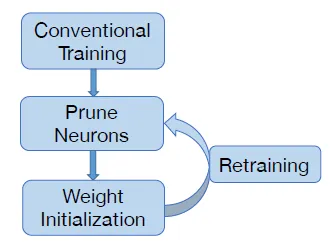

As your final task, create another model `CNN_MNIST_FNC` and `prune_and_train()` function where interactive pruning is implemented.

Then, run this function for 10 iterations with 10% L1 unstractured pruning for each iteration.

Finally, create the plot with accuracy as x-axis and sparsity as y-axis. Try to answer the following question: How sparse can a model get before the accuracy drops significantly?

In [46]:
CNN_MNIST_FNC = CNN(input_shape, output_size)
optimizer_FNC = torch.optim.SGD(CNN_MNIST_FNC.parameters(), lr=0.01)
CNN_MNIST_FNC.load_state_dict(torch.load(model_path))
optimizer_FNC.load_state_dict(torch.load(optimizer_path))

/var/folders/0b/brzkvl1j0tn9xzynh5pr39sw0000gn/T/ipykernel_41132/2720059131.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNN_MNIST_FNC.load_state_dict(torch.load(mode

In [47]:
def prune_and_train(
    model: torch.nn.Module,
    train_generator,
    test_generator,
    criterion,
    metric: BaseMetric,
    optimizer: torch.optim.Optimizer = None,
    step: float = 0.1,
    device=torch.device("cpu"),
    prunning_mode: str = "local",
):

    # TODO: Perform pruning
    if prunning_mode == 'local':
        prune.l1_unstructured(model.conv1, name='weight', amount=step)
        prune.l1_unstructured(model.conv2, name='weight', amount=step)
        prune.l1_unstructured(model.conv3, name="weight", amount=step)
    elif prunning_mode == 'global':
        prune.global_unstructured(
            parameters=[
                (model.conv1, 'weight'),
                (model.conv2, 'weight'),
                (model.conv3, 'weight'),
            ],
            pruning_method=prune.L1Unstructured,
            amount=step,
        )

    # TODO: Calculate sparsity
    sparsity = 100.0 * float(
                torch.sum(model.conv1.weight == 0)
                + torch.sum(model.conv2.weight == 0)
                + torch.sum(model.conv3.weight == 0)
            ) / float(
                model.conv1.weight.nelement()
                + model.conv2.weight.nelement()
                + model.conv3.weight.nelement()
            )

    # TODO: Train for 1 epoch with train_generator
    epoch_loss_train_CNN_MNIST_FNC, epoch_acc_train_CNN_MNIST_FNC = (
        train_one_epoch(
            model=model,
            train_loader=train_generator,
            loss_fn=criterion,
            metric=metric,
            device=device,
            update_period=1,
            optimizer=optimizer
        )
    )

    # TODO: Evaluate with test_generator
    epoch_loss_test_CNN_MNIST_FNC, epoch_acc_test_CNN_MNIST_FNC = (
        test_one_epoch(
            model=model,
            test_loader=test_generator,
            loss_fn=criterion,
            metric=metric,
            device=device,
        )
    )

    return (
        model,
        epoch_loss_train_CNN_MNIST_FNC,
        epoch_acc_train_CNN_MNIST_FNC,
        epoch_loss_test_CNN_MNIST_FNC,
        epoch_acc_test_CNN_MNIST_FNC,
        sparsity,
    )

In [48]:
train_accuracies = []
test_accuracies = []

train_losses = []
test_losses = []

sparsities = []

for i in range(10):
    CNN_MNIST_FNC, loss_train, acc_train, loss_test, acc_test, sparsity = prune_and_train(
        model=CNN_MNIST_FNC,
        train_generator=train_loader,
        test_generator=test_loader,
        criterion=loss_fcn,
        metric=metric,
        optimizer=optimizer_FNC,
        step=0.1,
        prunning_mode='local',
    )
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)

    train_losses.append(loss_train)
    test_losses.append(loss_test)

    sparsities.append(sparsity)

100%|██████████████████████████████| 157/157 [00:01<00:00, 110.24it/s, accuracy=0.9842, loss=1.4825]


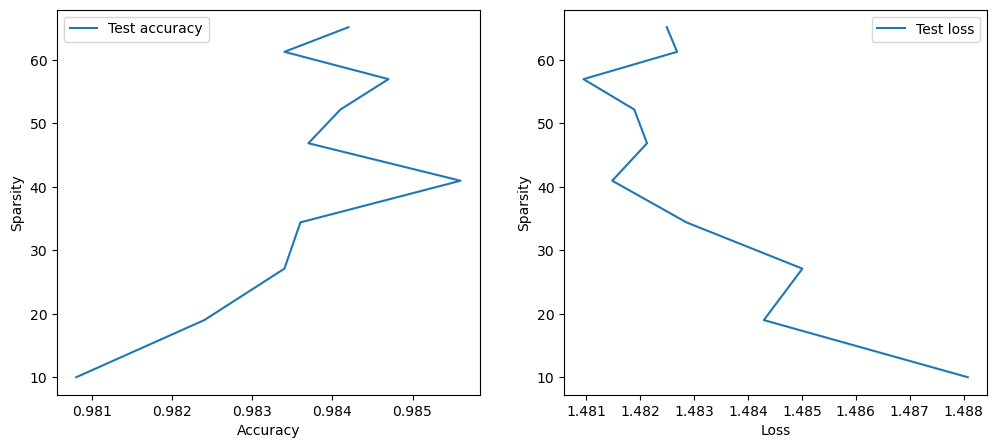

In [49]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# plt.plot(train_accuracies, sparsities, label="Train accuracy")
plt.plot(test_accuracies, sparsities, label="Test accuracy")
plt.ylabel("Sparsity")
plt.xlabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
# plt.plot(train_losses, sparsities, label="Train loss")
plt.plot(test_losses, sparsities, label="Test loss")
plt.ylabel("Sparsity")
plt.xlabel("Loss")
plt.legend()

plt.show()

# Global prunning

There is only one more stratgy to discuss: Global prunning. For now, we prunned weights for each convolution seperately. However, a common and perhaps more powerful technique is to prune the model all at once, by removing (for example) the lowest 20% of connections across the whole model, instead of removing the lowest 20% of connections in each layer.

For this purpose we use `prune.global_unstructured()` function that takes for input the following arguments:


* `parameters_to_prune = ((model.conv1, 'weights'),(...),(...))`
* `pruning_method=prune.L1Unstructured`
* `amount=...`

Let's try prunning not only Convolutional, but also Linear layers! Run this kind of prunning for a new Model (25% sparcity). Display sparsity of each layer after prunning and also for all layers together (sparsity for entire model).

In [50]:
CNN_MNIST_GLOBAL = CNN(input_shape, output_size)
optimizer_GLOBAL = torch.optim.SGD(CNN_MNIST_GLOBAL.parameters(), lr=0.01)
CNN_MNIST_GLOBAL.load_state_dict(torch.load(model_path))
optimizer_GLOBAL.load_state_dict(torch.load(optimizer_path))

prune.global_unstructured(
    parameters=[
        (CNN_MNIST_GLOBAL.conv1, 'weight'), 
        (CNN_MNIST_GLOBAL.conv2, 'weight'), 
        (CNN_MNIST_GLOBAL.conv3, 'weight'), 
        (CNN_MNIST_GLOBAL.fc, 'weight')
        ],
    pruning_method=prune.L1Unstructured,
    amount=0.25,
)
print("Conv1 sparsity: {:.2f}%".format(100.0 * float(torch.sum(CNN_MNIST_GLOBAL.conv1.weight == 0)) / float(CNN_MNIST_GLOBAL.conv1.weight.nelement())))
print("Conv2 sparsity: {:.2f}%".format(100.0 * float(torch.sum(CNN_MNIST_GLOBAL.conv2.weight == 0)) / float(CNN_MNIST_GLOBAL.conv2.weight.nelement())))
print("Conv3 sparsity: {:.2f}%".format(100.0 * float(torch.sum(CNN_MNIST_GLOBAL.conv3.weight == 0)) / float(CNN_MNIST_GLOBAL.conv3.weight.nelement())))
print("FC sparsity: {:.2f}%".format(100.0 * float(torch.sum(CNN_MNIST_GLOBAL.fc.weight == 0)) / float(CNN_MNIST_GLOBAL.fc.weight.nelement())))
print(
    "\nSparsity in CNN_MNIST_GLOBAL: {:.2f}%".format(
        100.0
        * float(
            torch.sum(CNN_MNIST_GLOBAL.conv1.weight == 0)
            + torch.sum(CNN_MNIST_GLOBAL.conv2.weight == 0)
            + torch.sum(CNN_MNIST_GLOBAL.conv3.weight == 0)
            + torch.sum(CNN_MNIST_GLOBAL.fc.weight == 0)
        )
        / float(
            CNN_MNIST_GLOBAL.conv1.weight.nelement()
            + CNN_MNIST_GLOBAL.conv2.weight.nelement()
            + CNN_MNIST_GLOBAL.conv3.weight.nelement()
            + CNN_MNIST_GLOBAL.fc.weight.nelement()
        )
    )
)

Conv1 sparsity: 3.12%
Conv2 sparsity: 16.02%
Conv3 sparsity: 22.65%
FC sparsity: 35.77%

Sparsity in CNN_MNIST_GLOBAL: 25.00%


/var/folders/0b/brzkvl1j0tn9xzynh5pr39sw0000gn/T/ipykernel_41132/987172996.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNN_MNIST_GLOBAL.load_state_dict(torch.load(mo

**Last exercise**

Let's try to find out - **How much can the CNN be prunned with Global prunning, until the accuracy drops significanty!** Update the function for iterative prunning from previous exercise with `prunning_mode` parameter that takes string `local` or `global`.

Run it again for global prunning of 10% of all weights for each iteration (10 iterations)

/var/folders/0b/brzkvl1j0tn9xzynh5pr39sw0000gn/T/ipykernel_41132/2578946629.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNN_MNIST_GLOBAL_2.load_state_dict(torch.load

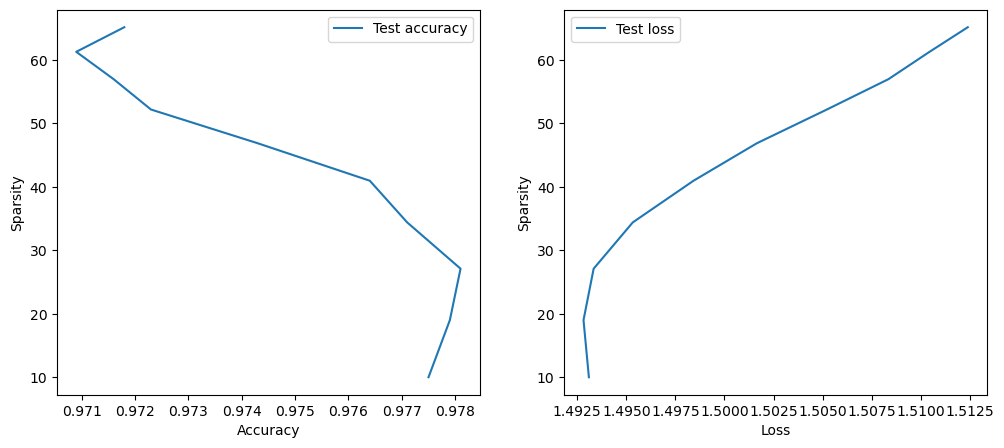

In [52]:
CNN_MNIST_GLOBAL_2 = CNN(input_shape, output_size)
optimizer_GLOBAL_2 = torch.optim.SGD(CNN_MNIST_GLOBAL_2.parameters(), lr=0.01)
CNN_MNIST_GLOBAL_2.load_state_dict(torch.load(model_path))
optimizer_GLOBAL_2.load_state_dict(torch.load(optimizer_path))

train_accuracies = []
test_accuracies = []

train_losses = []
test_losses = []

sparsities = []

for i in range(10):
    CNN_MNIST_GLOBAL_2, loss_train, acc_train, loss_test, acc_test, sparsity = (
        prune_and_train(
            model=CNN_MNIST_GLOBAL_2,
            train_generator=train_loader,
            test_generator=test_loader,
            criterion=loss_fcn,
            metric=metric,
            optimizer=optimizer_FNC,
            step=0.1,
            prunning_mode="global",
        )
    )
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)

    train_losses.append(loss_train)
    test_losses.append(loss_test)

    sparsities.append(sparsity)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# plt.plot(train_accuracies, sparsities, label="Train accuracy")
plt.plot(test_accuracies, sparsities, label="Test accuracy")
plt.ylabel("Sparsity")
plt.xlabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
# plt.plot(train_losses, sparsities, label="Train loss")
plt.plot(test_losses, sparsities, label="Test loss")
plt.ylabel("Sparsity")
plt.xlabel("Loss")
plt.legend()

plt.show()